<a target="_blank" href="https://colab.research.google.com/github/theochem/grid/blob/master/examples/JCP_Paper.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Grid publication examples

This notebook provides the examples of the use of [`qc-grid`](https://grid.qcdevs.org/index.html) provided in the publication article.

## Install dependencies and download data
This notebook requires several dependencies and data. The next cell will install the required dependencies if they are not already installed. It will also download the data required for the examples if it is not already downloaded.

In [1]:
# ! python -m pip install numpy
# ! python -m pip install matplotlib
# ! python -m pip install scipy
# ! python -m pip install urllib3
# ! python -m pip install git+https://github.com/theochem/grid.git
# ! python -m pip install git+https://github.com/theochem/iodata.git
# ! python -m pip install git+https://github.com/theochem/gbasis.git

# import os
# from urllib.request import urlretrieve

# # download the required data files
# file_path = "ch2o_q+0.fchk"
# if not os.path.isfile(file_path):
#     url = "https://github.com/theochem/grid/blob/master/examples/ch2o_q%2B0.fchk?raw=true"
#     urlretrieve(url, file_path)

## Grid Construction and Integration

### 1. Radial Grids: One-Dimensional Grids and Radial Transformation

The following example shows how to build a radial grid by combining a one-dimensional grid (e.g., Gauss-Chebyshev Type 2) and a radial transformation (e.g., Becke transformation).

In [2]:
import numpy as np
from grid.onedgrid import GaussChebyshevType2
from grid.rtransform import BeckeRTransform

# Generate 1D grid on [-1, 1] interval
oned = GaussChebyshevType2(30)
print("Number of 1D grid points: ", oned.size)   # outputs 30
print("Domain of 1D grid: ", oned.domain)        # outputs (-1, 1)

# Transform 1D grid using Becke transformation
rgrid = BeckeRTransform(1.e-4, 1.5).transform_1d_grid(oned)

# Integrate Gaussian s-function from 0 to infinity
integral = rgrid.integrate(np.exp(-0.5 * rgrid.points**2))
print("Integral of Gaussian s-function: ", integral)   # outputs sqrt(pi/2)

Number of 1D grid points:  30
Domain of 1D grid:  (-1, 1)
Integral of Gaussian s-function:  1.2525724696180882


### 2. Angular Grids

The following example shows construct and integrate over an angular grid.

In [21]:
import numpy as np
from grid import AngularGrid

# Make an instance of AngularGrid given a Lebedev-Laikov grid size
g = AngularGrid(size=140, method='spherical')
print("Number of angular grid points: ", g.size)   # outputs 146
print("Shape of angular grid points: ", g.points.shape)   # outputs (146, 3)
print("Shape of angular grid weights: ", g.weights.shape) # outputs (146,)

# Confirm that angular grid points are on the unit sphere
norm = np.linalg.norm(g.points, axis=1)
print("Norm of the grid points is all one:", np.all(np.abs(norm - 1.0) < 1e-8))

# Evaluate surface area of the unit sphere,
# i.e., integrate constant function 1
integral = g.integrate(np.ones(g.size))
print("Integral of constant function 1 over the sphere: ", integral)   # 4*pi

Number of atomic grid points:  1500
Number of atomic grid points:  264
Number of atomic grid points:  1036


### 3. Atomic Grid

The following example shows three ways to construct an atomic grid.

In [22]:
from grid.atomgrid import AtomGrid

# Option 1: using radial grid and degrees of Lebedev-Laikov angular grid
atgrid = AtomGrid(rgrid, degrees=[11])
print("Number of atomic grid points: ", atgrid.size) # outputs 1500

# Option 2: using radial grid and  atomic radius & sectors
atgrid = AtomGrid.from_pruned(
    rgrid, radius=0.5, r_sectors=[0.5, 1.0, 1.5], d_sectors=[3, 7, 5, 3]
)
print("Number of atomic grid points: ", atgrid.size) # outputs 264

# Option 3: using radial grid, atomic number, and preset
atgrid = AtomGrid.from_preset(atnum=1, preset="coarse", rgrid=rgrid)
print("Number of atomic grid points: ", atgrid.size) # outputs 1036

Number of atomic grid points:  1500
Number of atomic grid points:  264
Number of atomic grid points:  1036


### 4. Molecular Grid

A molecular grid is constructed by combining atomic grids centered at each atom. A molecular grid needs to use atoms in molecules (AIM) weights for achieving a proper integration over the molecular grid. The following example shows how to construct a molecular grid and integrate over it.

####  Provide data needed for molecular grid construction

Fist, we need the data needed for molecular grid construction, this includes the molecular geometry, the atomic numbers and for testing purpose, a way to get the function values at the grid points. In this example, we use formaldehyde as the molecule and as function values its electron density.

##### Select the AIM weights scheme

In [23]:
from grid.becke import BeckeWeights

# Make an instance of BeckeWeights class
aim_weights = BeckeWeights(radii=None, order=3)

##### Load formaldehyde molecule data (molecular geometry, nuclear charges and atomic coordinates)

In [24]:
from iodata import load_one

# Load formatted-checkpoint file of formaldehyde molecule.
# Source: https://github.com/theochem/grid/blob/master/examples/ch2o_q%2B0.fchk
mol = load_one("ch2o_q+0.fchk")

# Get atomic numbers, core numbers, and Cartesian coordinates
atnums, atcharges, atcoords = mol.atnums, mol.atcorenums, mol.atcoords

print("Atomic Numbers: ", atnums)
print("Atomic Core Charges: ", atcharges)
print("Atomic Coordinates: ", atcoords)

Atomic Numbers:  [8 6 1 1]
Atomic Core Charges:  [8. 6. 1. 1.]
Atomic Coordinates:  [[ 2.27823914e+00  4.13899085e-07  3.12033662e-07]
 [ 1.01154892e-02  1.09802629e-07 -6.99333116e-07]
 [-1.09577141e+00  1.77311416e+00  1.42544321e-07]
 [-1.09577166e+00 -1.77311468e+00  2.44755133e-07]]


#### Construct the molecular grid

-  **From a set of atomic grids (one for each atom)**

In [25]:
from grid.molgrid import MolGrid

# Option 1: Construct a molecular grid from atomic grids
atgrids = [
    AtomGrid(rgrid, degrees=[53], center=atcoords[0]),  # for oxygen
    AtomGrid(rgrid, degrees=[25], center=atcoords[1]),  # For carbon
    AtomGrid(rgrid, degrees=[10], center=atcoords[2]),  # for hydrogen 1
    AtomGrid(rgrid, degrees=[10], center=atcoords[3]),  # for hydrogen 2
]
molgrid = MolGrid(atnums, atgrids, aim_weights, store=True)

print("Number molecular grid points: ", molgrid.size)   # outputs 39120

Number molecular grid points:  39120


/mnt/Data/Work/Ayers/QC-Devs/grid/src/grid/atomgrid.py:879: UserWarning: Lebedev weights are negative which can introduce round-off errors.
  sphere_grid = AngularGrid(degree=deg_i, method=method)


-  **Using predefined pruned grids corresponding to each nucleus**

In [26]:
# Option 2: Construct a molecular grid from predefined pruned angular grids
molgrid = MolGrid.from_preset(
    atnums, atcoords, preset="fine", rgrid=rgrid, 
    aim_weights=aim_weights, store=True
)

print("Number molecular grid points: ", molgrid.size)   # outputs 10200

Number molecular grid points:  10200


-  **From the size of the angular grid**

In [27]:
# Option 3: Construct a molecular grid given size (40) of the angular grid
molgrid = MolGrid.from_size(
    atnums, atcoords, 40, rgrid, aim_weights, store=True
)

print("Number molecular grid points: ", molgrid.size)   # outputs 6000

Number molecular grid points:  6000


-  **From radial sectors and angular degrees associated with each sector**

In [10]:
# Option 4: Construct a molecular grid from user-defined pruned grids
sectors_r = [
    [0.25, 1.0, 1.5],   # for oxygen
    [0.50, 1.0, 1.5],   # for carbon
    [1.0],   # for hydrogen
    [1.0],   # for hydrogen
]
sectors_deg = [
    [10, 15, 25, 10],   # for oxygen
    [5, 10, 20, 10],   # for carbon
    [5, 10],   # for hydrogen
    [5, 10],   # for hydrogen
]
radius = 1.0
molgrid = MolGrid.from_pruned(
    atnums, atcoords, radius, sectors_r, sectors_deg, rgrid=rgrid, aim_weights=aim_weights, store=True
)

print("Number molecular grid points: ", molgrid.size)   # outputs 5664

Number molecular grid points:  5664


/mnt/Data/Work/Ayers/QC-Devs/grid/src/grid/atomgrid.py:879: UserWarning: Lebedev weights are negative which can introduce round-off errors.
  sphere_grid = AngularGrid(degree=deg_i, method=method)


#### Integrate molecular properties over the molecular grid

In [28]:
from gbasis.wrappers import from_iodata
from gbasis.evals.density import evaluate_density

# Evaluate the electron density in the grid points
basis = from_iodata(mol)
rdm = mol.one_rdms["scf"]
rho = evaluate_density(rdm, basis, molgrid.points)

print("Integral of electron density: ", molgrid.integrate(rho)) # outputs 16.00

Integral of electron density:  16.002942349252443


### 5. Cubic Grids

#### Construct uniform cubic grid from three axes, the corresponding step-sizes, the origin, and the shape (number of steps in each axis)

In [30]:
import numpy as np
from grid import UniformGrid

# Make 3D cubic grid centered at the origin with points 0.01 units apart
origin = np.array([0., 0., 0.])
axes = np.array([[0.01, 0., 0.], [0., 0.01, 0.], [0., 0., 0.01]])
shape = np.array([50, 50, 50])
g = UniformGrid(origin, axes, shape, weight="Trapezoid")

print("Number of cubic grid points: ", g.size)   # outputs 125000

Number of cubic grid points:  125000


#### Construct a uniform cubic grid from molecule specifications

In [31]:
# Construct a cubic grid with additional padding of 5 
# and points 0.2 units apart
g = UniformGrid.from_molecule(
    atnums, atcoords, spacing=0.2, extension=5.0, rotate=True
)

print("Number of cubic grid points: ", g.size) # outputs 232356

Number of cubic grid points:  232356


#### Construct non-uniform cubic grid from three one-dimensional (their tensor product) 

In [33]:
from grid import GaussChebyshevType2, GaussLegendre, Tensor1DGrids

# Make instances of 1D grids
oned1 = GaussChebyshevType2(30)
oned2 = GaussLegendre(20)
oned3 = GaussLegendre(30)

# Make Tensor1DGrids grid by combining 1D grids
g = Tensor1DGrids(oned1, oned2, oned3)

print("cubic grid # of points: ", g.size)      # outputs 18000

cubic grid # of points:  18000


## Interpolation and Differentiation:

The following example interpolates the electron density in the plane containing the formaldehyde.

In [34]:
import numpy as np

# Sample 100 points uniformly along x and y axes
x_vals = np.linspace(-4, 4, 100)
y_vals = x_vals

# Sample 3D points uniformly in the molecular xy-plane (z=0)
x_vals, y_vals = np.meshgrid(x_vals, y_vals)
x_vals, y_vals = x_vals.flatten(), y_vals.flatten()
z_vals = np.zeros_like(x_vals)
points = np.array([x_vals, y_vals, z_vals]).T # interpolation requires 3D points

# Interpolate electron density in the xy-plane
func_interpolation = molgrid.interpolate(rho)
rho_inter = func_interpolation(points=points)

# Compute expected electron density using GBasis
rho_expected = evaluate_density(rdm, basis, points)

# Compare interpolated and expected electron density
max_error = np.max(abs(rho_inter - rho_expected))
print("Maximum interpolation error: ", max_error) # outputs 0.219

Maximum interpolation error:  0.21840761269320312088


Compute gradient from the interpolated electron density.

In [35]:
# Compute the gradient at the interpolated points
grad_rho_inter = func_interpolation(points=points, deriv=1)

(optional) Code for plotting the electron density in fromaldehyde plane.

/home/marco/miniconda3/envs/grid_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Casting input data from float128 to float64 for imshow
  fig.canvas.print_figure(bytes_io, **kw)


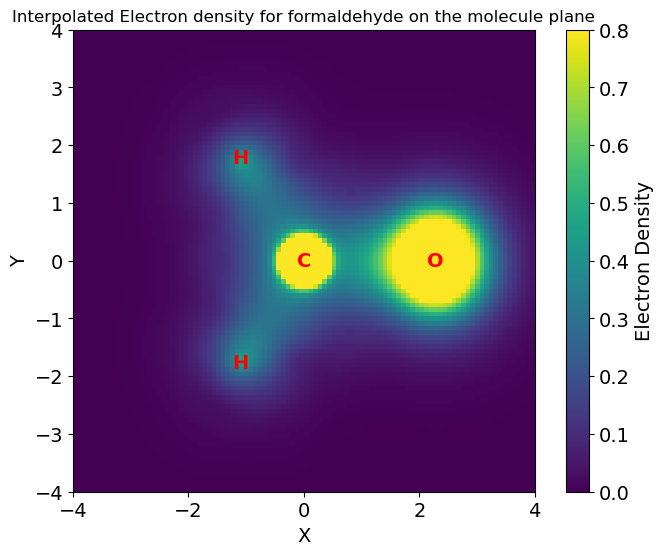

In [17]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)

# Plot the interpolated electron density as a 2D heatmap with specified color scale limits
heatmap = ax1.imshow(rho_inter.reshape(100,100), cmap="viridis", interpolation="none", extent=[-4, 4, -4, 4], vmin=0, vmax=0.8)
cbar = plt.colorbar(heatmap, ax=ax1, label="Electron Density")
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_ylabel("Electron Density", fontsize=14) 

# Add symbols to the corresponding coordinates
xy_coords = mol.atcoords[:, :2]

symbols = ['O', 'C', 'H', 'H']

for coord, symbol in zip(xy_coords, symbols):
    ax1.text(coord[0], coord[1], symbol, color='red', ha='center', va='center', fontsize=14,fontweight='bold')

ax1.tick_params(axis='both', which='both', labelsize=14)
# Adjust the limits to fit your data and set labels and title
ax1.set_xlim((-4, 4))
ax1.set_ylim((-4, 4))
ax1.set_xlabel("X", fontsize=14)
ax1.set_ylabel("Y", fontsize=14)
ax1.set_title("Interpolated Electron density for formaldehyde on the molecule plane")
plt.show()


## Solving Poisson Equation

The following example solves the Poisson equation on an atomic grid for unit-charge distribution:

\begin{equation}
    \rho(r, \theta, \phi) = \bigg( \frac{\alpha}{\pi} \bigg)^{1.5} e^{-\alpha r_A^2},
\end{equation}
where $\alpha = 0.25$ and $r_A$ is the radius centered at the coordinate $[0, 1, 0]$.

In [38]:
import numpy as np
from grid.poisson import solve_poisson_bvp
from grid.rtransform import BeckeRTransform, InverseRTransform
from scipy.special import erf

center = np.array([0, 1, 0])

def charge_distribution(r, alpha=0.25):
    r_a = np.linalg.norm(r - center, axis=1)
    return (alpha / np.pi) ** (3.0 / 2.0) * np.exp(-alpha * r_a**2.0)

def actual_potential(x, alpha=0.25):
    r_a = np.linalg.norm(x - center, axis=1)
    desired = erf(np.sqrt(alpha) * r_a) / r_a
    desired[r_a == 0.0] = 0.0
    return desired

# define atomic grid at the center of the potential
btf = BeckeRTransform(1.e-4, 1.5)
atgrid = AtomGrid.from_preset(atnum=1, preset="fine", rgrid=rgrid, center=center)

# Evaluate unit-charge density on atomic grid points
func_vals = charge_distribution(atgrid.points)

# Solve for the potential and evaluate it on atomic grid points
potential = solve_poisson_bvp(
        atgrid,
        func_vals,
        InverseRTransform(btf),
        include_origin=True,
        remove_large_pts=7.0,
)
potential_values = potential(atgrid.points)

# Calculate the error between actual and solved potential
err = np.abs(actual_potential(atgrid.points) - potential_values)
print(f"Max: {np.max(err)}, Mean: {np.mean(err)}, Std: {np.std(err)}")
# outputs Max: 1.932e-04, Mean: 5.998e-05, Std: 2.809e-05

Max: 0.00019316659753122433, Mean: 5.9977081365250616e-05, Std: 2.8093917704795297e-05


## Multipole Moments
The following example illustrates how to use Grid's moment function to calculate the dipole moment $\mu$ of formaldehyde.

In [43]:
# Calculate the center of mass of the molecule
center = np.matmul(mol.atmasses, atcoords) / np.sum(mol.atmasses)
center = center[None,:]

# calculate centered coordinates
atcoords_cent = atcoords - center

# Calculate the Cartesian moments of the electron density
integrals, orders = molgrid.moments(
    1, center, rho, type_mom="cartesian", return_orders=True
)
# calculate (X_a - X_c)**{n_x} (Y_a - Y_c)**{n_y} (Z_a - Z_c)**{n_z}
cent_pts_with_order = (atcoords_cent ** orders[:, None])
# multiply over each corresponding moment axis (row)
cent_pts_with_order = np.prod(cent_pts_with_order, axis=2)
# calculate Z_a (X_a - X_c)**{n_x} (Y_a - Y_c)**{n_y} (Z_a - Z_c)**{n_z}
result = np.einsum("ij,j->i", cent_pts_with_order, atcharges)

# sum electric dipole moment and remove [0,0,0] moment value
result = (result - integrals.T).flatten()[1:]

# Print dipole moment vector (should be the same as the dipole in FCHK file)
print("Dipole moment: ", result)
# ouputs -9.398e-01 -4.076e-04 -6.545e-06

Dipole moment:  [-9.30638843e-01  5.34979418e-04 -1.05420179e-02]
